# OS

In [1]:
import os 
os.getcwd()

'/Users/carlahugod/Desktop/UNI/3sem/ML'

In [6]:
os.chdir(os.getcwd() + '/Toolbox_Python/Scripts')

In [7]:
os.getcwd()

'/Users/carlahugod/Desktop/UNI/3sem/ML/Toolbox_Python/Scripts'

# Prepare data

In [2]:
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
import sklearn.linear_model as lm
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy import stats

In [3]:
# We want to predict the gamma gtp level based on the level of drinking.

os.chdir('/Users/carlahugod/Desktop/UNI/3sem/ML/Project1/')
filename = 'sd-data_cleanedv6.csv'
data = pd.read_csv(filename)
# Drinking is the last column and the one we use for prediction
# Gamma gtp is the third last column
gamma_gtp = data.iloc[:,-3] # this is y

# Replace the numbers with the names of the attributes
names = ['SMK1', '2', '3', 'hear_right1', '2.1', 'hear_left1', '2.2', 'sex', 'age',
 'height', 'weight' ,'waistline', 'sight_left', 'sight_right','SBP', 'DBP',
 'BLDS' ,'tot_chole', 'HDL_chole' ,'LDL_chole', 'triglyceride', 'hemoglobin',
 'urine_protein', 'serum_creatinine' ,'SGOT_AST' ,'SGOT_ALT', 'gamma_GTP',
 'DRK_YN']

# Replace the numbers with the names of the attributes
data.columns = names
# change directory back so i can import the toolbox from the course
os.chdir('/Users/carlahugod/Desktop/UNI/3sem/ML/Toolbox_Python/Scripts')
from Master import rlr_validate

# turn the data into an np array instead of pd dataframe. Regression data = reg_data
X = data.values

# remove the drinking column.
y = X[:,-1]
X = np.delete(X, -1, axis=1)

In [9]:
# Last colummn of data:
drink = data.iloc[:,-1]
# turn to np array
drink = drink.values
# why is the (1111,) instead od (1111,1) ?? Because of numpy idiocy. Therefore I rehspae.
y = drink.reshape(991346,1)


# Linear regression model

In [9]:
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
N, M = X.shape

# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0

In [12]:

for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 5
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1


show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(names[m], np.round(w_rlr[m,-1],2)))




IndexError: index 5 is out of bounds for axis 0 with size 5

# ANN for regression:

Training model of type:

Sequential(
  (0): Linear(in_features=28, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)



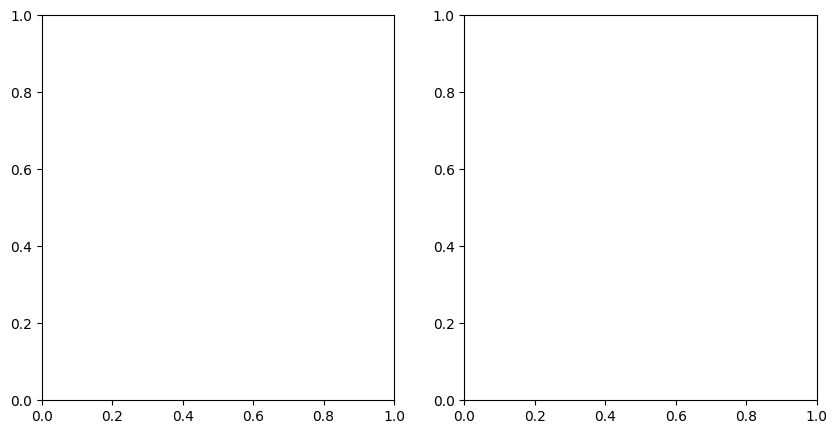

In [57]:
from Master import train_neural_net, draw_neural_net
# Normalize data
X = stats.zscore(X)
                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0)
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 5      # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10          # number of iterations

# K-fold crossvalidation
K = 2
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']


# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )

loss_fn = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop

In [67]:
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])

# print size of training set
print('\nSize of training set: {0}'.format(X_train.shape))
print('\nSize of test set: {0}'.format(X_test.shape))
print('\nSize of training set: {0}'.format(y_train.shape))


Crossvalidation fold: 1/2

Crossvalidation fold: 2/2

Size of training set: torch.Size([495673, 27])

Size of test set: torch.Size([495673, 27])

Size of training set: torch.Size([495673])


In [42]:
     # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    

    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')


	Replicate: 1/1
		Iter	Loss			Rel. loss


RuntimeError: mat1 and mat2 shapes cannot be multiplied (495673x27 and 28x5)

In [60]:


# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')
    
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=names)

# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of 
# the true/known value - these values should all be along a straight line "y=x", 
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10,10))
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true, y_est,'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Alcohol content: estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

plt.show()

print('Ran Exercise 8.2.5')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

# ANN for classification

991346 27 (991346, 1)
Training model of type:
Sequential(
  (0): Linear(in_features=27, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)


	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.55266476	1.725563e-05
		2000	0.54566604	9.284704e-06
		3000	0.537791	1.3964682e-05
		4000	0.5319392	7.955601e-06
		5000	0.527479	7.344887e-06
		Final loss:
		5207	0.5267244	1.13160986e-07

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.5576933	2.0519983e-05
		2000	0.546398	2.4762023e-05
		3000	0.5391157	1.1055879e-05
		4000	0.5319806	1.3108847e-05
		Final loss:
		4398	0.52977294	5.625487e-07

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.55743843	2.6837699e-05
		2000	0.54744965	1.1758571e-05
		3000	0.54145753	1.2218936e-05
		4000	0.53325456	1.4530568e-05
		Final loss:
		4442	0.53034973	4.4954993e-07

	Best loss: 0.5267243981361389



AssertionError: TwoFeatureError: Current neural_net_decision_boundary is only implemented for 2 features.

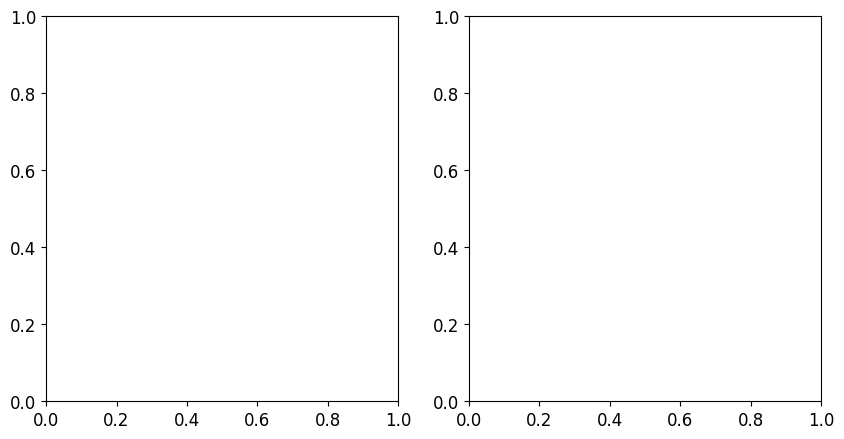

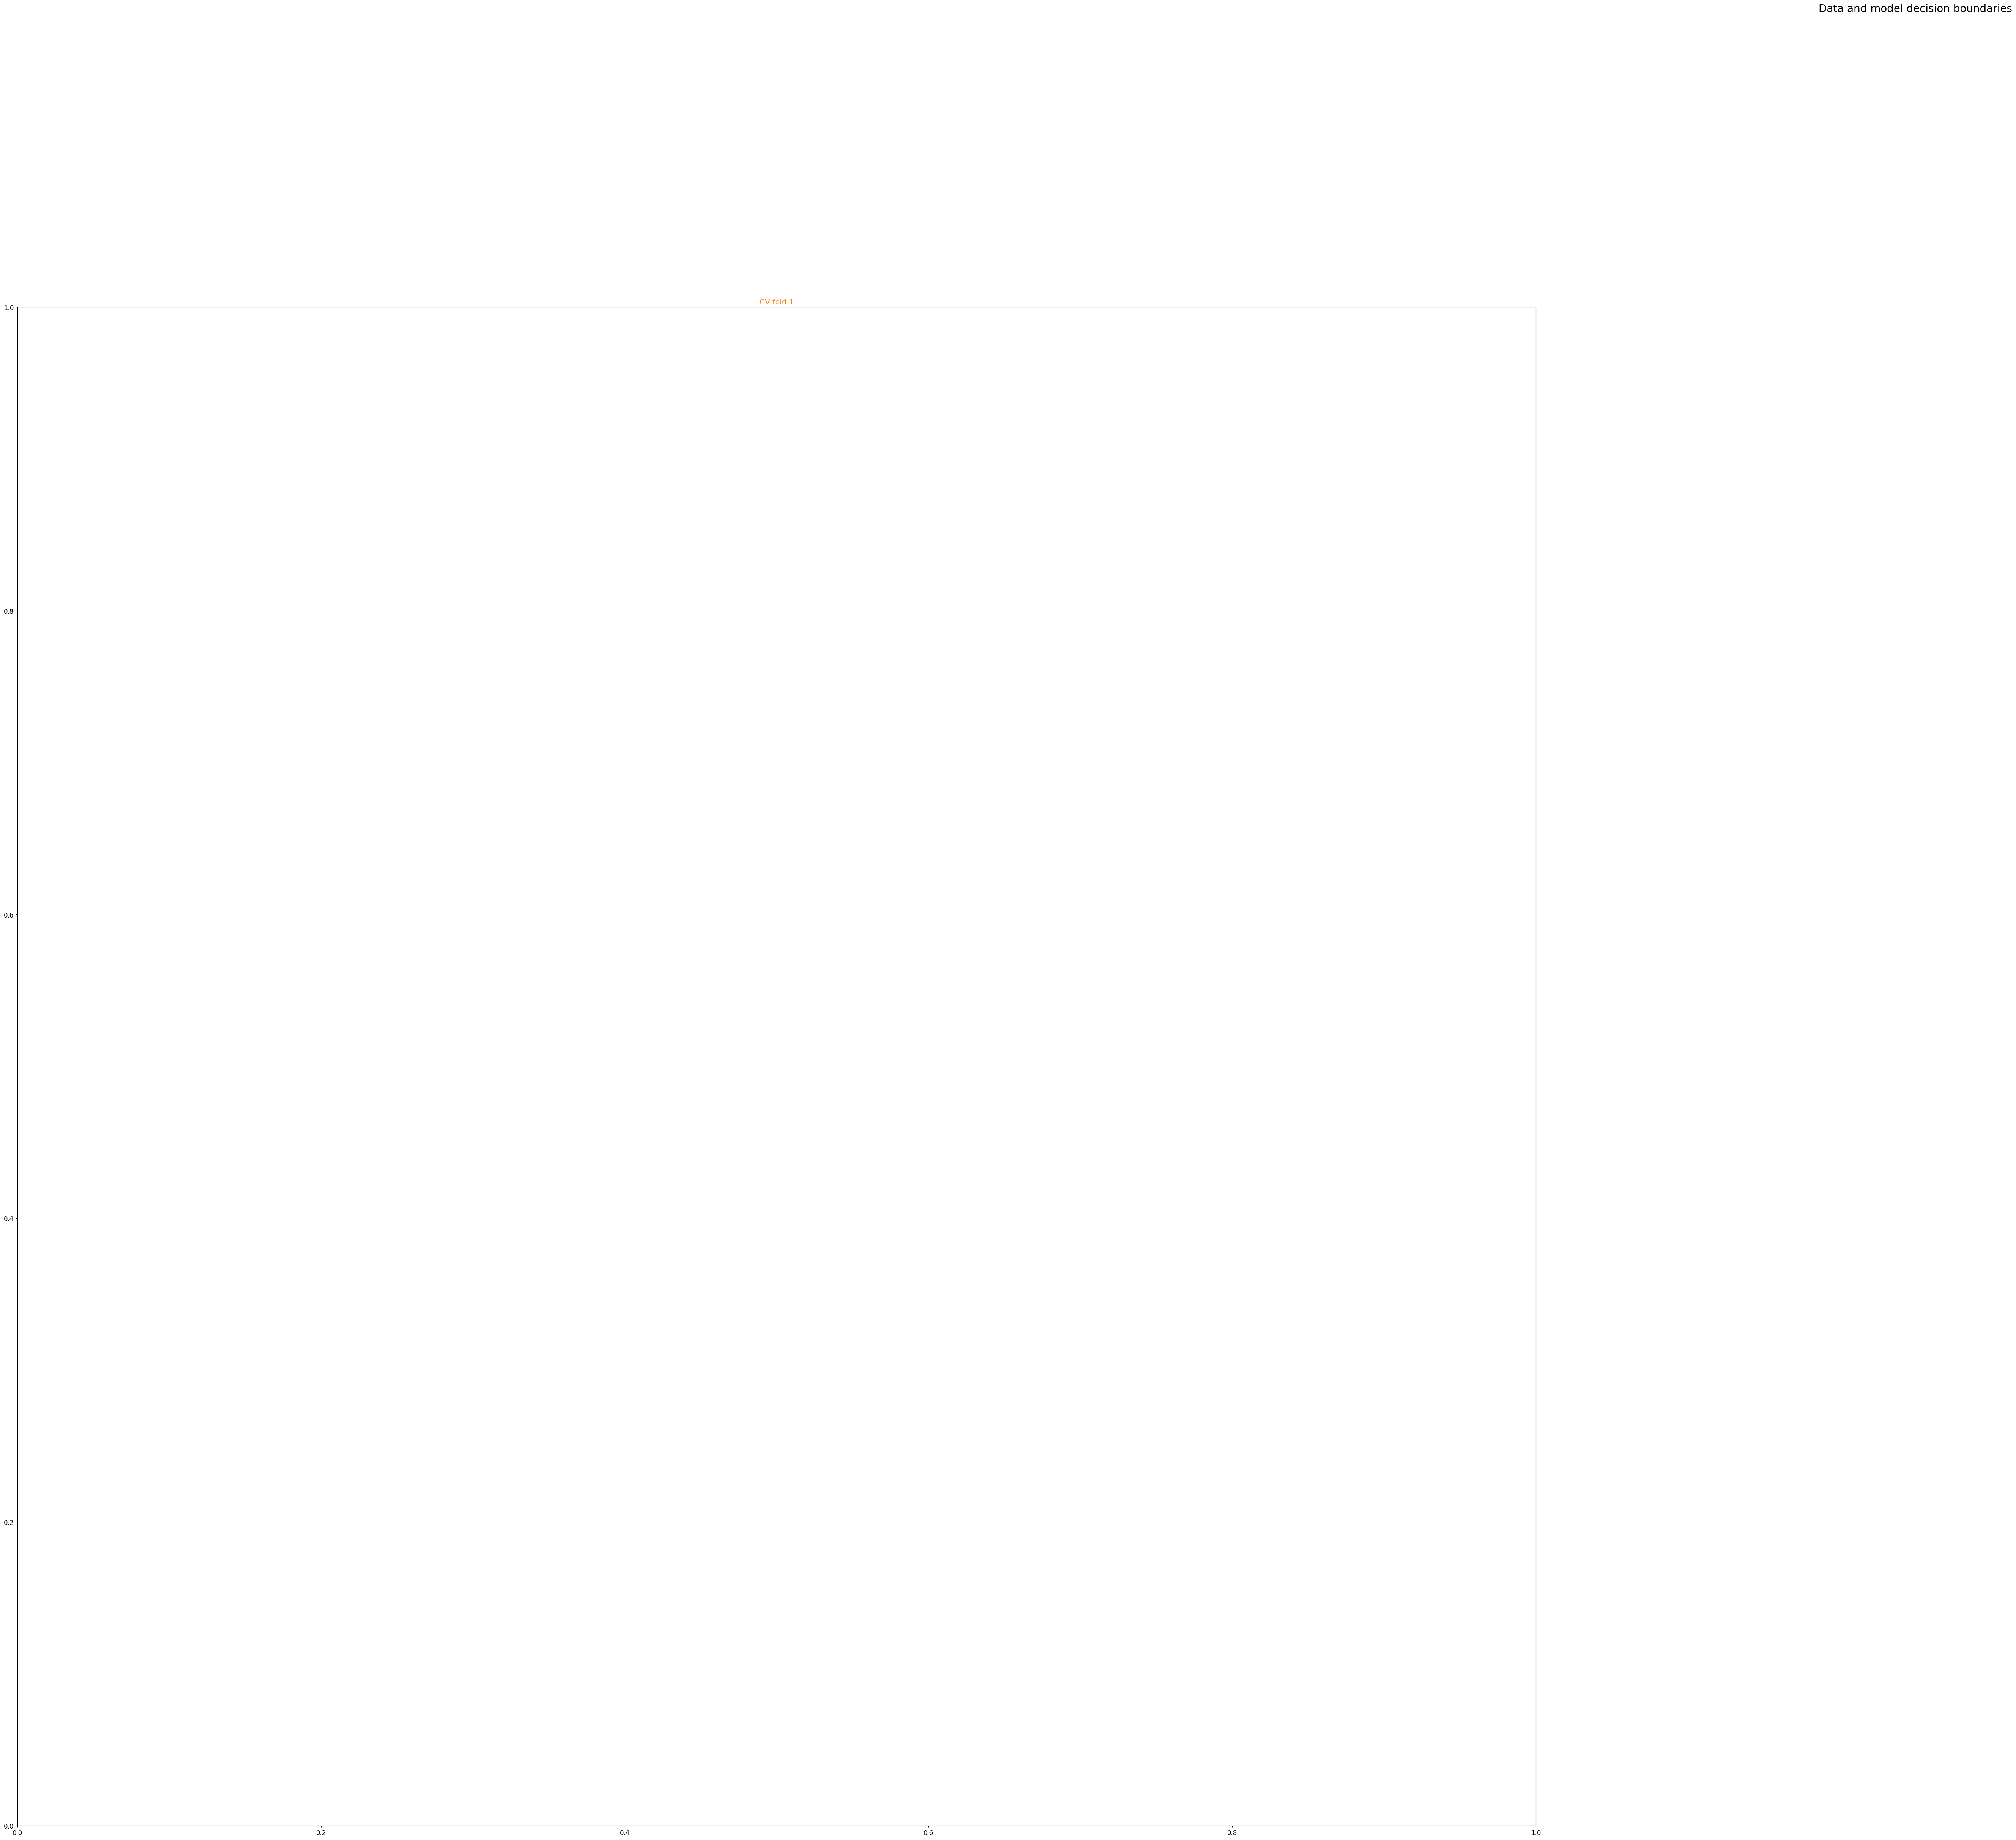

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from Master import train_neural_net, draw_neural_net, visualize_decision_boundary
import torch
plt.rcParams.update({'font.size': 12})


attributeNames = names
classNames = ['Low', 'High']
N, M = X.shape
print(N,M, y.shape)
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K,shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(100,100))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K))) 
subplot_size_2 = int(np.ceil(K/subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle('Data and model decision boundaries', fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']



# Define the model structure
n_hidden_units = 10 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.ReLU(),                            #torch.nn.ReLU() or torch.nn.Tanh(), or torch.nn.Sigmoid()
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )


# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()


# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))


# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:

for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    #print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:] )
    y_train = torch.Tensor(y[train_index] )
    X_test = torch.Tensor(X[test_index,:] )
    y_test = torch.Tensor(y[test_index] )
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Make a subplot for current cross validation fold that displays the 
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means 
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1,subplot_size_2,k+1)
    plt.title('CV fold {0}'.format(k+1),color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(predict, X, y, # provide data, along with function for prediction
                                attributeNames, classNames, # provide information on attribute and class names
                                train=train_index, test=test_index, # provide information on partioning
                                show_legend=k==(K-1)) # only display legend for last plot
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

In [ ]:

    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')
    
# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran exercise 8.2.2.')


	Replicate: 1/3
		Iter	Loss			Rel. loss


ValueError: Using a target size (torch.Size([743509])) that is different to the input size (torch.Size([743509, 1])) is deprecated. Please ensure they have the same size.